# Bike Sharing Demand


## columns


  * **datetime** - 시간(연-월-일 시:분:초)
  * **season** - 계절(봄(1), 여름(2), 가을(3), 겨울(4))
  * **holiday** - 공휴일(1 공휴일)
  * **workingday** - 근무일(1 근무일)
  * **weather** - 날씨(낮을 수록 좋음)
  * **temp** - 온도
  * **atemp** - 체감 온도
  * **humidity** - 습도
  * **windspeed** - 풍속
  * **casual** - 비회원(non-registered)의 자전거 대여량
  * **registered** - 회원(registered)의 자전거 대여량
  * **count** - 총 자전거 대여랑(비회원(casual) + 회원(registered))

In [67]:
import pandas as pd

# xgboost 사용하면서 kernel자꾸 죽는 경우 사용
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

## Load Dataset

In [3]:
train = pd.read_csv("../dataSet/train.csv", parse_dates=["datetime"])
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test = pd.read_csv("../dataSet/test.csv", parse_dates=["datetime"])
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Preprocessing

### Parse datetime

In [6]:
train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-minute"] = train["datetime"].dt.minute
train["datetime-second"] = train["datetime"].dt.second

train["datetime-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)

train[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute", "datetime-second", "datetime-dayofweek"]].head()

(10886, 19)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,2011,1,1,4,0,0,5


In [7]:
train.loc[train["datetime-dayofweek"] == 0, "datetime-dayofweek(humanized)"] = "Monday"
train.loc[train["datetime-dayofweek"] == 1, "datetime-dayofweek(humanized)"] = "Tuesday"
train.loc[train["datetime-dayofweek"] == 2, "datetime-dayofweek(humanized)"] = "Wednesday"
train.loc[train["datetime-dayofweek"] == 3, "datetime-dayofweek(humanized)"] = "Thursday"
train.loc[train["datetime-dayofweek"] == 4, "datetime-dayofweek(humanized)"] = "Friday"
train.loc[train["datetime-dayofweek"] == 5, "datetime-dayofweek(humanized)"] = "Saturday"
train.loc[train["datetime-dayofweek"] == 6, "datetime-dayofweek(humanized)"] = "Sunday"

print(train.shape)

train[["datetime", "datetime-dayofweek", "datetime-dayofweek(humanized)"]].head()

(10886, 20)


,datetime,datetime-dayofweek,datetime-dayofweek(humanized)
0,2011-01-01 00:00:00,5,Saturday
1,2011-01-01 01:00:00,5,Saturday
2,2011-01-01 02:00:00,5,Saturday
3,2011-01-01 03:00:00,5,Saturday
4,2011-01-01 04:00:00,5,Saturday


In [8]:
test["datetime-year"] = test["datetime"].dt.year
test["datetime-month"] = test["datetime"].dt.month
test["datetime-day"] = test["datetime"].dt.day
test["datetime-hour"] = test["datetime"].dt.hour
test["datetime-minute"] = test["datetime"].dt.minute
test["datetime-second"] = test["datetime"].dt.second

test["datetime-dayofweek"] = test["datetime"].dt.dayofweek

print(test.shape)

test[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute", "datetime-second", "datetime-dayofweek"]].head()

(6493, 16)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,2011,1,20,4,0,0,3


In [9]:
test.loc[test["datetime-dayofweek"] == 0, "datetime-dayofweek(humanized)"] = "Monday"
test.loc[test["datetime-dayofweek"] == 1, "datetime-dayofweek(humanized)"] = "Tuesday"
test.loc[test["datetime-dayofweek"] == 2, "datetime-dayofweek(humanized)"] = "Wednesday"
test.loc[test["datetime-dayofweek"] == 3, "datetime-dayofweek(humanized)"] = "Thursday"
test.loc[test["datetime-dayofweek"] == 4, "datetime-dayofweek(humanized)"] = "Friday"
test.loc[test["datetime-dayofweek"] == 5, "datetime-dayofweek(humanized)"] = "Saturday"
test.loc[test["datetime-dayofweek"] == 6, "datetime-dayofweek(humanized)"] = "Sunday"

print(test.shape)

test[["datetime", "datetime-dayofweek", "datetime-dayofweek(humanized)"]].head()

(6493, 17)


,datetime,datetime-dayofweek,datetime-dayofweek(humanized)
0,2011-01-20 00:00:00,3,Thursday
1,2011-01-20 01:00:00,3,Thursday
2,2011-01-20 02:00:00,3,Thursday
3,2011-01-20 03:00:00,3,Thursday
4,2011-01-20 04:00:00,3,Thursday


### fillin_windspeed

In [51]:
# train, test내 windspeed 0이 없을 때까지 반복. 0이 있는 값은 앞 뒤 값의 평균으로 대체
train["prev-windspeed"] = train["windspeed"].shift(+1)
train["next-windspeed"] = train["windspeed"].shift(-1)
test["prev-windspeed"] = test["windspeed"].shift(+1)
test["next-windspeed"] = test["windspeed"].shift(-1)

train.loc[train["prev-windspeed"].isnull(), "prev-windspeed"] = 0
train.loc[train["next-windspeed"].isnull(), "next_windspeed"] = 0
test.loc[test["prev-windspeed"].isnull(), "prev-windspeed"] = 0
test.loc[test["next-windspeed"].isnull(), "next-windspeed"] = 0

train["av-windspeed"] = (train["prev-windspeed"] + train["next-windspeed"]) /2
test["av-windspeed"] = (test["prev-windspeed"] + test["next-windspeed"]) / 2

train.loc[train["windspeed"] == 0, "windspeed"] = train["av-windspeed"]
test.loc[test["windspeed"] == 0, "windspeed"] = test["av-windspeed"]

In [52]:
train.loc[train["windspeed"] == 0].shape

(0, 33)

In [48]:
test.loc[test["windspeed"] == 0].shape

(0, 20)

## Explore

### datetime

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


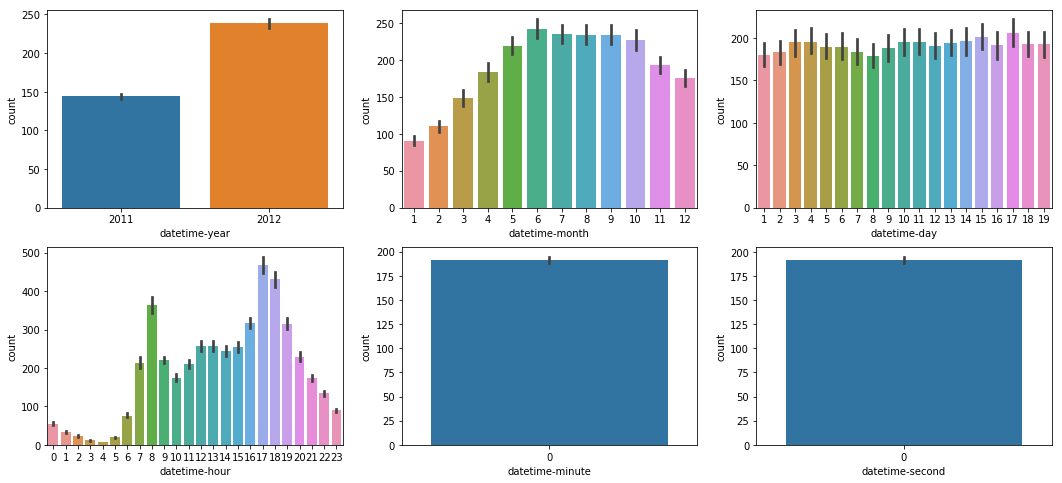

In [10]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)

figure.set_size_inches(18, 8)

sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)
sns.barplot(data=train, x="datetime-day", y="count", ax=ax3)
sns.barplot(data=train, x="datetime-hour", y="count", ax=ax4)
sns.barplot(data=train, x="datetime-minute", y="count", ax=ax5)
sns.barplot(data=train, x="datetime-second", y="count", ax=ax6)

### datetime-year & datetime-month

In [11]:
train["datetime-year(str)"] = train["datetime-year"].astype('str')
train["datetime-month(str)"] = train["datetime-month"].astype('str')

train["datetime-year_month"] = train["datetime-year(str)"] + "-" + train["datetime-month(str)"]

print(train.shape)

train[["datetime", "datetime-year_month"]].head()

(10886, 23)


,datetime,datetime-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


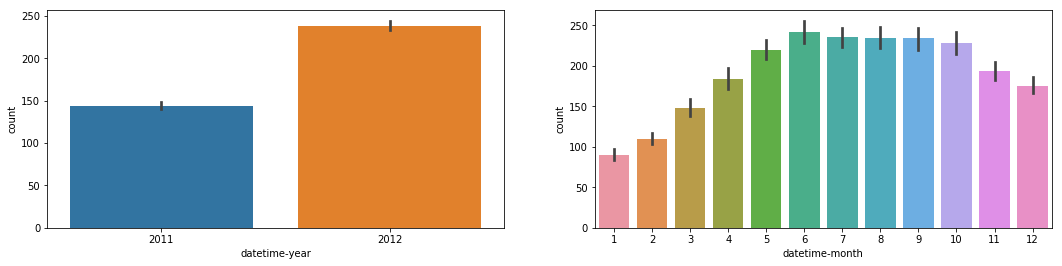

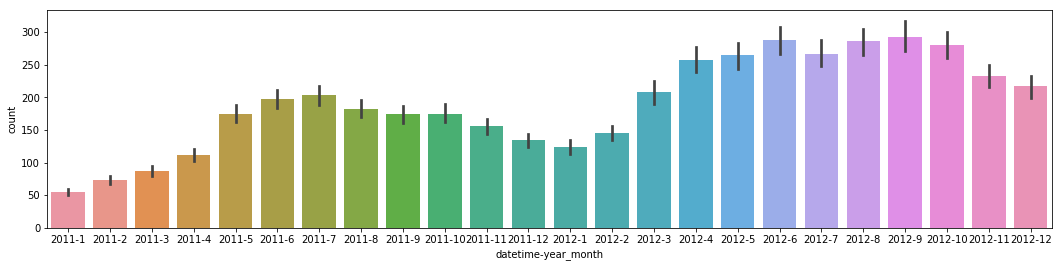

In [12]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

figure.set_size_inches(18, 4)

sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)

figure.set_size_inches(18, 4)

sns.barplot(data=train, x="datetime-year_month", y="count", ax=ax3)

### datetime-hour

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


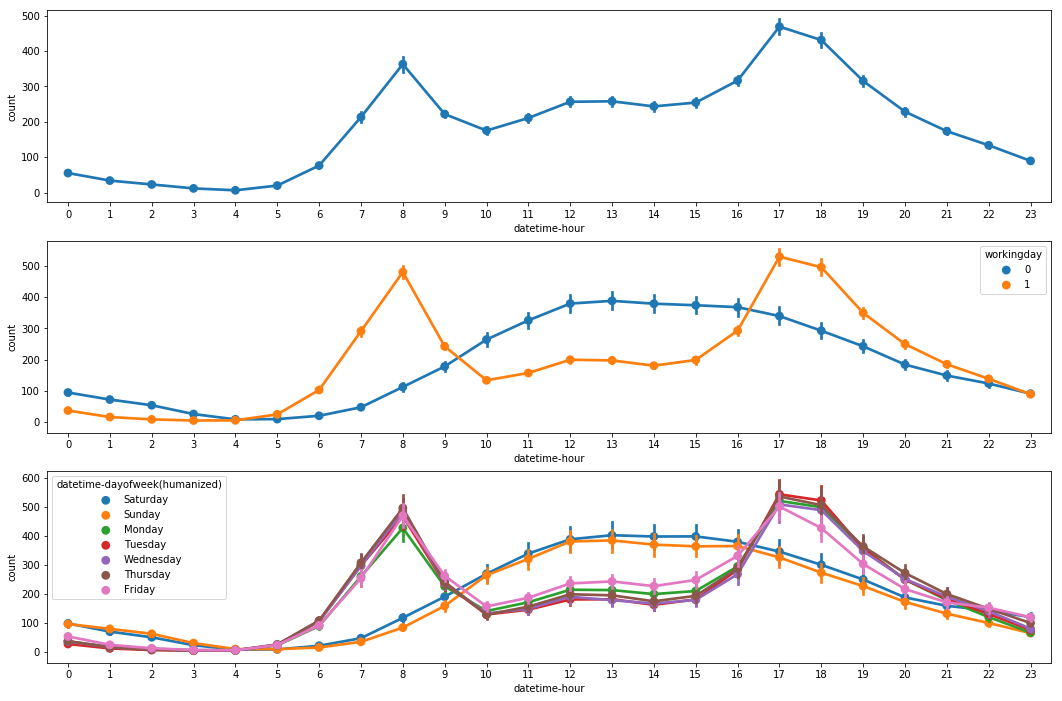

In [13]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

figure.set_size_inches(18, 12)

sns.pointplot(data=train, x="datetime-hour", y="count", ax=ax1)

sns.pointplot(data=train, x="datetime-hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="datetime-hour", y="count", hue="datetime-dayofweek(humanized)", ax=ax3)

### count

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


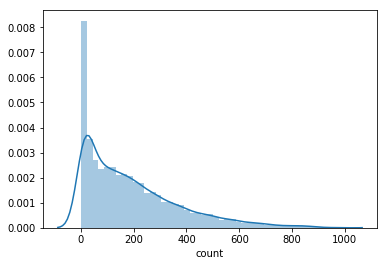

In [14]:
sns.distplot(train["count"])

In [15]:
train["log_count"] = np.log(train["count"] + 1)

print(train.shape)

train[["count", "log_count"]].head()

(10886, 24)


,count,log_count
0,16,2.833213
1,40,3.713572
2,32,3.496508
3,13,2.639057
4,1,0.693147


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


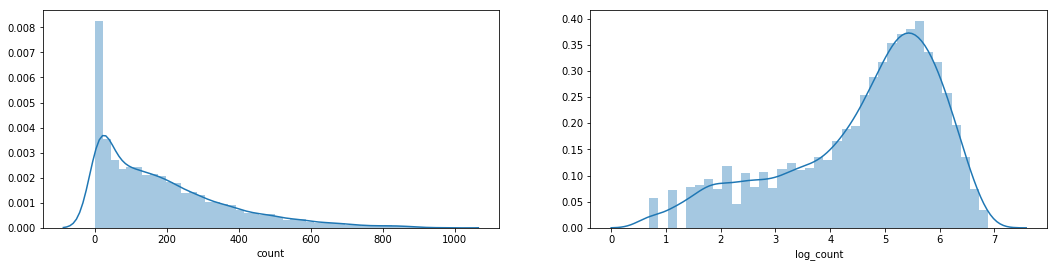

In [16]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

figure.set_size_inches(18, 4)

sns.distplot(train["count"], ax=ax1)

sns.distplot(train["log_count"], ax=ax2)

In [17]:
# log transformation한 자전거 대여량(log_count)을 다시 exp로 원상복귀 시킨다
train["count(recover)"] = np.exp(train["log_count"]) - 1

print(train.shape)

train[["count", "log_count", "count(recover)"]].head()

(10886, 25)


,count,log_count,count(recover)
0,16,2.833213,16.0
1,40,3.713572,40.0
2,32,3.496508,32.0
3,13,2.639057,13.0
4,1,0.693147,1.0


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


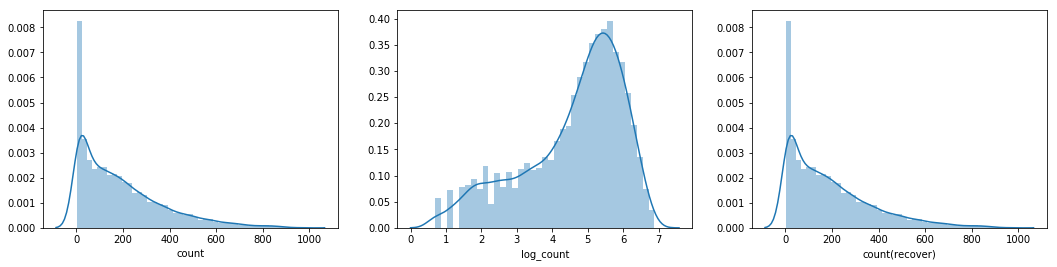

In [29]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

figure.set_size_inches(18, 4)

sns.distplot(train["count"], ax=ax1)

sns.distplot(train["log_count"], ax=ax2)

sns.distplot(train["count(recover)"], ax=ax3)

### count_registered

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


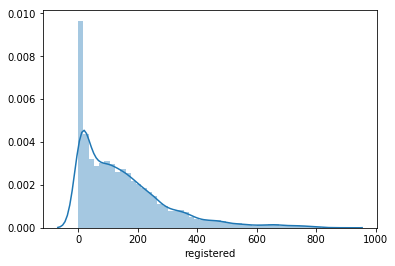

In [20]:
sns.distplot(train["registered"])

In [21]:
train["log_registered"] = np.log(train["registered"] + 1)

print(train.shape)

train[["registered", "log_registered"]].head()

(10886, 26)


,registered,log_registered
0,13,2.639057
1,32,3.496508
2,27,3.332205
3,10,2.397895
4,1,0.693147


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


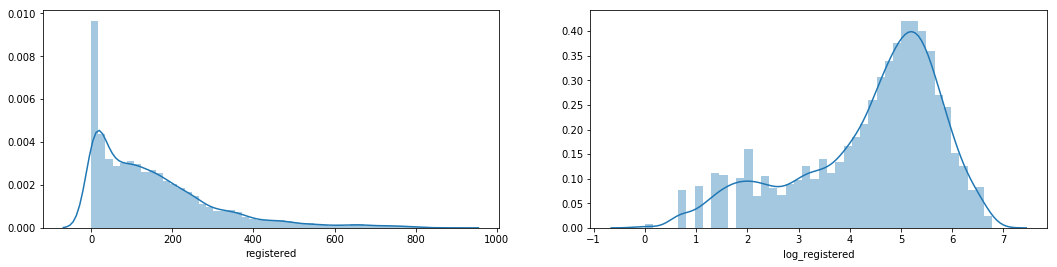

In [22]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

figure.set_size_inches(18, 4)

sns.distplot(train["registered"], ax=ax1)

sns.distplot(train["log_registered"], ax=ax2)

In [23]:
# log transformation한 자전거 대여량(log_count)을 다시 exp로 원상복귀 시킨다
train["registered(recover)"] = np.exp(train["log_registered"]) - 1

print(train.shape)

train[["registered", "log_registered", "registered(recover)"]].head()

(10886, 27)


,registered,log_registered,registered(recover)
0,13,2.639057,13.0
1,32,3.496508,32.0
2,27,3.332205,27.0
3,10,2.397895,10.0
4,1,0.693147,1.0


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


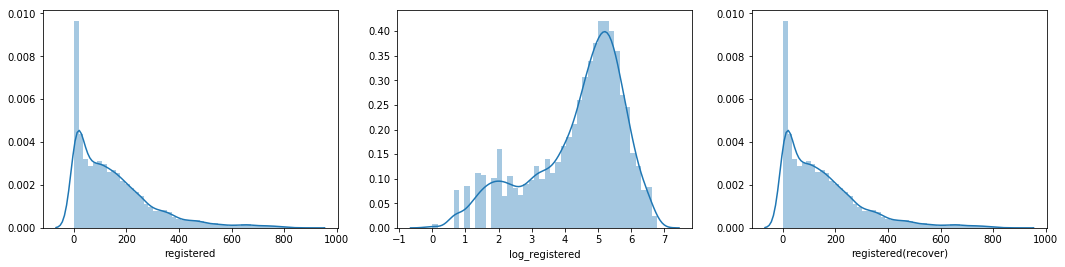

In [30]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

figure.set_size_inches(18, 4)

sns.distplot(train["registered"], ax=ax1)

sns.distplot(train["log_registered"], ax=ax2)

sns.distplot(train["registered(recover)"], ax=ax3)

### count_casual

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


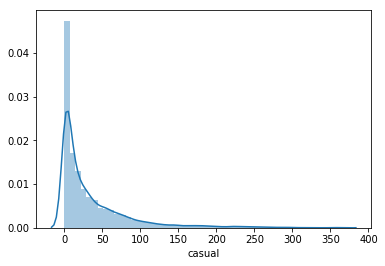

In [24]:
sns.distplot(train["casual"])

In [26]:
train["log_casual"] = np.log(train["casual"] + 1)

print(train.shape)

train[["casual", "log_casual"]].head()

(10886, 28)


,casual,log_casual
0,3,1.386294
1,8,2.197225
2,5,1.791759
3,3,1.386294
4,0,0.000000


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


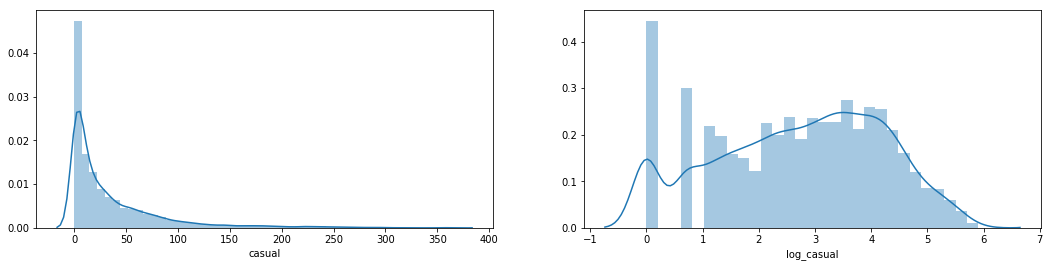

In [27]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

figure.set_size_inches(18, 4)

sns.distplot(train["casual"], ax=ax1)

sns.distplot(train["log_casual"], ax=ax2)

In [28]:
# log transformation한 자전거 대여량(log_count)을 다시 exp로 원상복귀 시킨다
train["casual(recover)"] = np.exp(train["log_casual"]) - 1

print(train.shape)

train[["casual", "log_casual", "casual(recover)"]].head()

(10886, 29)


,casual,log_casual,casual(recover)
0,3,1.386294,3.0
1,8,2.197225,8.0
2,5,1.791759,5.0
3,3,1.386294,3.0
4,0,0.000000,0.0


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


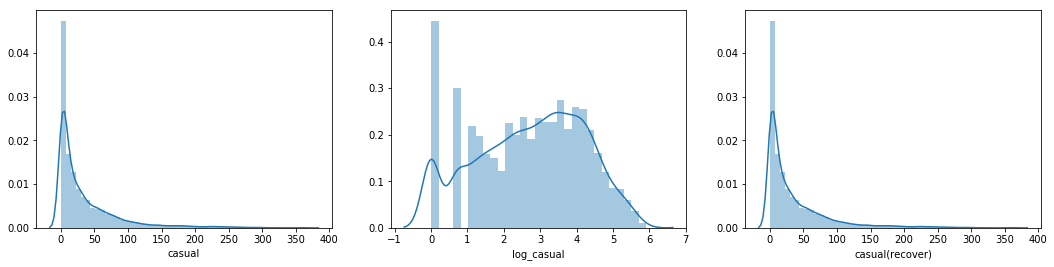

In [31]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

figure.set_size_inches(18, 4)

sns.distplot(train["casual"], ax=ax1)

sns.distplot(train["log_casual"], ax=ax2)

sns.distplot(train["casual(recover)"], ax=ax3)

## Train - log_registered

In [54]:
feature_names = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "datetime-year", "datetime-hour", "datetime-dayofweek"]
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'datetime-year',
 'datetime-hour',
 'datetime-dayofweek']

In [55]:
label_name = "log_registered"
label_name

'log_registered'

In [56]:
X_train = train[feature_names]

print(X_train.shape)

X_train.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,0,1,9.84,14.395,81,0.1876,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.3752,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.7504,2011,2,5
3,1,0,0,1,9.84,14.395,75,1.5008,2011,3,5
4,1,0,0,1,9.84,14.395,75,3.0016,2011,4,5


In [57]:
X_test = test[feature_names]

print(X_test.shape)

X_test.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,1,1,10.66,11.365,56,26.00270,2011,0,3
1,1,0,1,1,10.66,13.635,56,13.00135,2011,1,3
2,1,0,1,1,10.66,13.635,56,5.50070,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.00140,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.00140,2011,4,3


In [58]:
y_train = train[label_name]

print(y_train.shape)

y_train.head()

(10886,)


0    2.639057
1    3.496508
2    3.332205
3    2.397895
4    0.693147
Name: log_registered, dtype: float64

### Evaluate

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (p_i - a_i)^2 } $$

In [60]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual
    
    square_distance = distance ** 2
    
    mean_square_distance = square_distance.mean()
    
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_score = make_scorer(rmse)
rmse_score

make_scorer(rmse)

## Hyperparameter Tuning

In [66]:
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Coarse & Finer Search

**Coarse Search**

In [26]:
from sklearn.model_selection import cross_val_score

# 랜덤 서치를 반복할 횟수
num_epoch = 100

coarse_hyperparameters_list = []

for epoch in range(num_epoch):
    # 트리 갯수
    n_estimators = np.random.randint(low=100, high=1000)
    # 트리 깊이
    max_depth = np.random.randint(low=2, high=100)
    # 트리 비중
    learning_rate = 10 ** -np.random.uniform(low=0, high=10)
    # 하나의 트리를 만들 때 사용할 데이터의 비율
    subsample = np.random.uniform(low=0.1, high=1.0)
    # 하나의 트리를 만들 때 사용할 feature의 비율
    colsample_bytree = np.random.uniform(low=0.4, high=1.0)
    # 트리가 한 번 가지를 칠 때 사용할 feature의 비율
    colsample_bylevel = np.random.uniform(low=0.4, high=1.0)

    model = xgb.XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             colsample_bylevel=colsample_bylevel,
                             colsample_bytree=colsample_bytree,
                             seed=37)

    # cv. Cross Validation에서 데이터를 조각낼(split) 갯수
    # scoring. rmse를 사용한 점수 측정 공식
    # 이 함수의 실행 결과의 평균(mean)을 구한 뒤 score라는 이름의 새로운 변수에 할당
    score = cross_val_score(model, X_train, y_train, cv=20, scoring=rmse_score).mean()
    
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bytree': colsample_bytree,
    }

    coarse_hyperparameters_list.append(hyperparameters)

    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, learning_rate = {learning_rate:.10f}, subsample = {subsample:.6f}, colsample_bylevel = {colsample_bylevel:.6f}, colsample_bytree = {colsample_bytree:.6f}, Score = {score:.5f}")


# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

# 변환한 coarse_hyperparameters_list를 score가 낮은 순으로 정렬
# (RMSE는 score가 낮을 수록 더 정확도가 높다)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)

coarse_hyperparameters_list.head(10)

 0 n_estimators = 699, max_depth = 24, learning_rate = 0.2322858010, subsample = 0.345621, colsample_bylevel = 0.768295, colsample_bytree = 0.477353, Score = 0.45069
 1 n_estimators = 932, max_depth = 27, learning_rate = 0.0209459632, subsample = 0.289088, colsample_bylevel = 0.863977, colsample_bytree = 0.890338, Score = 0.32996
 2 n_estimators = 138, max_depth = 68, learning_rate = 0.0000000047, subsample = 0.733244, colsample_bylevel = 0.943907, colsample_bytree = 0.656607, Score = 4.31058
 3 n_estimators = 747, max_depth = 18, learning_rate = 0.0049878620, subsample = 0.715803, colsample_bylevel = 0.612042, colsample_bytree = 0.848196, Score = 0.37242
 4 n_estimators = 149, max_depth = 49, learning_rate = 0.2041003999, subsample = 0.124723, colsample_bylevel = 0.886809, colsample_bytree = 0.988393, Score = 0.44243
 5 n_estimators = 636, max_depth = 16, learning_rate = 0.0000000030, subsample = 0.504256, colsample_bylevel = 0.547654, colsample_bytree = 0.631089, Score = 4.31057
 6 n

50 n_estimators = 426, max_depth = 27, learning_rate = 0.1464556134, subsample = 0.543915, colsample_bylevel = 0.473488, colsample_bytree = 0.733188, Score = 0.37602
51 n_estimators = 699, max_depth =  7, learning_rate = 0.0262003173, subsample = 0.513865, colsample_bylevel = 0.631298, colsample_bytree = 0.971718, Score = 0.32117
52 n_estimators = 400, max_depth = 76, learning_rate = 0.0000000044, subsample = 0.244632, colsample_bylevel = 0.507006, colsample_bytree = 0.634038, Score = 4.31057
53 n_estimators = 192, max_depth = 89, learning_rate = 0.0000179771, subsample = 0.916516, colsample_bylevel = 0.892634, colsample_bytree = 0.900298, Score = 4.29620
54 n_estimators = 814, max_depth =  3, learning_rate = 0.1425177568, subsample = 0.250722, colsample_bylevel = 0.681453, colsample_bytree = 0.840537, Score = 0.33576
55 n_estimators = 501, max_depth = 21, learning_rate = 0.0000000450, subsample = 0.145558, colsample_bylevel = 0.755875, colsample_bytree = 0.601645, Score = 4.31049
56 n

,colsample_bylevel,colsample_bytree,epoch,learning_rate,max_depth,n_estimators,score,subsample
51,0.631298,0.971718,51,0.026200,7,699,0.321169,0.513865
47,0.467062,0.835914,47,0.039993,5,403,0.321592,0.651052
1,0.863977,0.890338,1,0.020946,27,932,0.329961,0.289088
54,0.681453,0.840537,54,0.142518,3,814,0.335763,0.250722
25,0.468473,0.869623,25,0.022928,59,868,0.336911,0.404547
83,0.551960,0.774964,83,0.030294,50,743,0.337546,0.321904
6,0.897664,0.930401,6,0.079119,13,181,0.340025,0.778489
80,0.527225,0.982032,80,0.088809,71,742,0.342985,0.884192
42,0.943843,0.491711,42,0.365611,4,774,0.345367,0.999501
39,0.403381,0.623426,39,0.014757,84,779,0.355085,0.306529


**Finer Search**

In [38]:
import xgboost as xgb

from sklearn.model_selection import cross_val_score

num_epoch = 100

finer_hyperparameters_list = []

for epoch in range(num_epoch):

    n_estimators = np.random.randint(low=300, high=1000)

    max_depth = np.random.randint(low=2, high=60)

    learning_rate = 10 ** -np.random.uniform(low=0, high=2)

    subsample = np.random.uniform(low=0.2, high=0.7)

    colsample_bytree = np.random.uniform(low=0.7, high=1.0)

    colsample_bylevel = np.random.uniform(low=0.4, high=1.0)

    model = xgb.XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             colsample_bylevel=colsample_bylevel,
                             colsample_bytree=colsample_bytree,
                             seed=37)

    score = cross_val_score(model, X_train, y_train, cv=20, scoring=rmse_score).mean()

    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bytree': colsample_bytree,
    }

    finer_hyperparameters_list.append(hyperparameters)

    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, learning_rate = {learning_rate:.10f}, subsample = {subsample:.6f}, colsample_bylevel = {colsample_bylevel:.6f}, colsample_bytree = {colsample_bytree:.6f}, Score = {score:.5f}")


finer_hyperparameters_list = pd.DataFrame.from_dict(finer_hyperparameters_list)

finer_hyperparameters_list = finer_hyperparameters_list.sort_values(by="score")

print(finer_hyperparameters_list.shape)

finer_hyperparameters_list.head(10)

 0 n_estimators = 826, max_depth = 26, learning_rate = 0.0140914189, subsample = 0.604440, colsample_bylevel = 0.803958, colsample_bytree = 0.958276, Score = 0.33072
 1 n_estimators = 693, max_depth = 19, learning_rate = 0.0204163085, subsample = 0.281243, colsample_bylevel = 0.842756, colsample_bytree = 0.922510, Score = 0.32868
 2 n_estimators = 578, max_depth = 21, learning_rate = 0.0367275403, subsample = 0.673859, colsample_bylevel = 0.694686, colsample_bytree = 0.775183, Score = 0.34194
 3 n_estimators = 556, max_depth = 35, learning_rate = 0.0206988792, subsample = 0.311399, colsample_bylevel = 0.730884, colsample_bytree = 0.920663, Score = 0.32868
 4 n_estimators = 786, max_depth = 11, learning_rate = 0.0352740882, subsample = 0.394929, colsample_bylevel = 0.497259, colsample_bytree = 0.946960, Score = 0.33906
 5 n_estimators = 462, max_depth =  8, learning_rate = 0.0217484971, subsample = 0.601801, colsample_bylevel = 0.435530, colsample_bytree = 0.907742, Score = 0.32755
 6 n

50 n_estimators = 660, max_depth = 53, learning_rate = 0.1744916417, subsample = 0.429841, colsample_bylevel = 0.894033, colsample_bytree = 0.908646, Score = 0.36765
51 n_estimators = 323, max_depth = 53, learning_rate = 0.2742895948, subsample = 0.317018, colsample_bylevel = 0.618159, colsample_bytree = 0.861279, Score = 0.42262
52 n_estimators = 575, max_depth =  3, learning_rate = 0.0504267387, subsample = 0.655626, colsample_bylevel = 0.572267, colsample_bytree = 0.911976, Score = 0.33836
53 n_estimators = 646, max_depth =  6, learning_rate = 0.4478130499, subsample = 0.677061, colsample_bylevel = 0.863480, colsample_bytree = 0.964276, Score = 0.40714
54 n_estimators = 805, max_depth =  2, learning_rate = 0.1437046472, subsample = 0.641922, colsample_bylevel = 0.468121, colsample_bytree = 0.877805, Score = 0.38581
55 n_estimators = 864, max_depth = 38, learning_rate = 0.0257201746, subsample = 0.582692, colsample_bylevel = 0.791519, colsample_bytree = 0.905579, Score = 0.33344
56 n

,colsample_bylevel,colsample_bytree,epoch,learning_rate,max_depth,n_estimators,score,subsample
92,0.870122,0.980396,92,0.011105,10,859,0.321325,0.362207
64,0.679378,0.901412,64,0.046622,8,326,0.323925,0.684720
35,0.547196,0.854189,35,0.028520,8,855,0.324446,0.402216
32,0.684372,0.971310,32,0.016790,34,554,0.326180,0.425722
27,0.831264,0.867055,27,0.025435,54,385,0.326442,0.266720
6,0.845876,0.966426,6,0.019466,57,315,0.327296,0.313923
5,0.435530,0.907742,5,0.021748,8,462,0.327548,0.601801
41,0.561755,0.960961,41,0.023364,11,437,0.327625,0.321998
77,0.790567,0.925351,77,0.071885,3,985,0.327687,0.285630
96,0.667323,0.948886,96,0.026588,28,349,0.328221,0.392322


In [72]:
best_hyperparameters = finer_hyperparameters_list.iloc[0]

best_n_estimators = int(best_hyperparameters["n_estimators"])

best_max_depth = int(best_hyperparameters["max_depth"])

best_learning_rate = best_hyperparameters["learning_rate"]

best_subsample = best_hyperparameters["subsample"]

best_colsample_bytree = best_hyperparameters["colsample_bytree"]

best_colsample_bylevel = best_hyperparameters["colsample_bylevel"]

print(f"n_estimators(best) = {best_n_estimators}, max_depth(best) = {best_max_depth}, learning_rate(best) = {best_learning_rate:.6f}, subsample(best) = {best_subsample:.6f}, colsample_bytree(best) = {best_colsample_bytree:.6f}, colsample_bylevel(best) = {best_colsample_bylevel:.6f}")

n_estimators(best) = 859, max_depth(best) = 10, learning_rate(best) = 0.011105, subsample(best) = 0.362207, colsample_bytree(best) = 0.980396, colsample_bylevel(best) = 0.870122


## Use Gradient Boosting Machine

In [68]:
# 주의: 혹시 하이퍼패러미터 튜닝을 하는데 시간이 너무 오래 걸려 아래의 것을 사용
best_n_estimators = 859
best_max_depth = 10
best_learning_rate = 0.011105
best_subsample = 0.362207
best_colsample_bytree = 0.980396
best_colsample_bylevel = 0.870122

model = xgb.XGBRegressor(n_estimators=best_n_estimators,
                         max_depth=best_max_depth,
                         learning_rate=best_learning_rate,
                         subsample=best_subsample,
                         colsample_bytree=best_colsample_bytree,
                         colsample_bylevel=best_colsample_bylevel,
                         seed=37)

model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.870122,
       colsample_bytree=0.980396, gamma=0, learning_rate=0.011105,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=859, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=37, silent=True, subsample=0.362207)

## Fit

In [69]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.870122,
       colsample_bytree=0.980396, gamma=0, learning_rate=0.011105,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=859, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=37, silent=True, subsample=0.362207)

## Predict

In [71]:
log_predictions_reg = model.predict(X_test)

print(log_predictions_reg.shape)

log_predictions_reg

(6493,)


array([2.591149 , 1.7800393, 1.3072813, ..., 4.6390724, 4.3923664,
       3.7156725], dtype=float32)

In [73]:
predictions_reg = np.exp(log_predictions_reg) - 1

print(predictions_reg.shape)

predictions_reg

(6493,)


array([ 12.345098 ,   4.9300895,   2.6961112, ..., 102.44835  ,
        79.831474 ,  40.08621  ], dtype=float32)

## Train, Evaluate, Hyperparameter tuning, Fit, Predict를 casual에 대해서도 똑같이 반복

## Train - log_casual

In [74]:
feature_names = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "datetime-year", "datetime-hour", "datetime-dayofweek"]
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'datetime-year',
 'datetime-hour',
 'datetime-dayofweek']

In [75]:
label_name = "log_casual"
label_name

'log_casual'

In [76]:
X_train = train[feature_names]

print(X_train.shape)

X_train.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,0,1,9.84,14.395,81,0.1876,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.3752,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.7504,2011,2,5
3,1,0,0,1,9.84,14.395,75,1.5008,2011,3,5
4,1,0,0,1,9.84,14.395,75,3.0016,2011,4,5


In [77]:
X_test = test[feature_names]

print(X_test.shape)

X_test.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,1,1,10.66,11.365,56,26.00270,2011,0,3
1,1,0,1,1,10.66,13.635,56,13.00135,2011,1,3
2,1,0,1,1,10.66,13.635,56,5.50070,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.00140,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.00140,2011,4,3


In [78]:
y_train = train[label_name]

print(y_train.shape)

y_train.head()

(10886,)


0    1.386294
1    2.197225
2    1.791759
3    1.386294
4    0.000000
Name: log_casual, dtype: float64

### Coarse & Finer Search

**Coarse Search**

In [ ]:
from sklearn.model_selection import cross_val_score

# 랜덤 서치를 반복할 횟수
num_epoch = 100

coarse_hyperparameters_list = []

for epoch in range(num_epoch):
    # 트리 갯수
    n_estimators = np.random.randint(low=100, high=1000)
    # 트리 깊이
    max_depth = np.random.randint(low=2, high=100)
    # 트리 비중
    learning_rate = 10 ** -np.random.uniform(low=0, high=10)
    # 하나의 트리를 만들 때 사용할 데이터의 비율
    subsample = np.random.uniform(low=0.1, high=1.0)
    # 하나의 트리를 만들 때 사용할 feature의 비율
    colsample_bytree = np.random.uniform(low=0.4, high=1.0)
    # 트리가 한 번 가지를 칠 때 사용할 feature의 비율
    colsample_bylevel = np.random.uniform(low=0.4, high=1.0)

    model = xgb.XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             colsample_bylevel=colsample_bylevel,
                             colsample_bytree=colsample_bytree,
                             seed=37)

    # cv. Cross Validation에서 데이터를 조각낼(split) 갯수
    # scoring. rmse를 사용한 점수 측정 공식
    # 이 함수의 실행 결과의 평균(mean)을 구한 뒤 score라는 이름의 새로운 변수에 할당
    score = cross_val_score(model, X_train, y_train, cv=20, scoring=rmse_score).mean()
    
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bytree': colsample_bytree,
    }

    coarse_hyperparameters_list.append(hyperparameters)

    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, learning_rate = {learning_rate:.10f}, subsample = {subsample:.6f}, colsample_bylevel = {colsample_bylevel:.6f}, colsample_bytree = {colsample_bytree:.6f}, Score = {score:.5f}")


# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

# 변환한 coarse_hyperparameters_list를 score가 낮은 순으로 정렬
# (RMSE는 score가 낮을 수록 더 정확도가 높다)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)

coarse_hyperparameters_list.head(10)

**Finer Search**

In [ ]:
import xgboost as xgb

from sklearn.model_selection import cross_val_score

num_epoch = 100

finer_hyperparameters_list = []

for epoch in range(num_epoch):

    n_estimators = np.random.randint(low=300, high=1000)

    max_depth = np.random.randint(low=2, high=60)

    learning_rate = 10 ** -np.random.uniform(low=0, high=2)

    subsample = np.random.uniform(low=0.2, high=0.7)

    colsample_bytree = np.random.uniform(low=0.7, high=1.0)

    colsample_bylevel = np.random.uniform(low=0.4, high=1.0)

    model = xgb.XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             colsample_bylevel=colsample_bylevel,
                             colsample_bytree=colsample_bytree,
                             seed=37)

    score = cross_val_score(model, X_train, y_train, cv=20, scoring=rmse_score).mean()

    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bytree': colsample_bytree,
    }

    finer_hyperparameters_list.append(hyperparameters)

    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, learning_rate = {learning_rate:.10f}, subsample = {subsample:.6f}, colsample_bylevel = {colsample_bylevel:.6f}, colsample_bytree = {colsample_bytree:.6f}, Score = {score:.5f}")


finer_hyperparameters_list = pd.DataFrame.from_dict(finer_hyperparameters_list)

finer_hyperparameters_list = finer_hyperparameters_list.sort_values(by="score")

print(finer_hyperparameters_list.shape)

finer_hyperparameters_list.head(10)

## Use Gradient Boosting Machine

In [79]:
# 주의: 혹시 하이퍼패러미터 튜닝을 하는데 시간이 너무 오래 걸려 아래의 것을 사용
best_n_estimators = 859
best_max_depth = 10
best_learning_rate = 0.011105
best_subsample = 0.362207
best_colsample_bytree = 0.980396
best_colsample_bylevel = 0.870122

model = xgb.XGBRegressor(n_estimators=best_n_estimators,
                         max_depth=best_max_depth,
                         learning_rate=best_learning_rate,
                         subsample=best_subsample,
                         colsample_bytree=best_colsample_bytree,
                         colsample_bylevel=best_colsample_bylevel,
                         seed=37)

model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.870122,
       colsample_bytree=0.980396, gamma=0, learning_rate=0.011105,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=859, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=37, silent=True, subsample=0.362207)

## Fit

In [80]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.870122,
       colsample_bytree=0.980396, gamma=0, learning_rate=0.011105,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=859, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=37, silent=True, subsample=0.362207)

## Predict

In [81]:
log_predictions_cas = model.predict(X_test)

print(log_predictions_cas.shape)

log_predictions_cas

(6493,)


array([0.98075026, 0.35700682, 0.5388382 , ..., 1.419481  , 1.3844514 ,
       0.85419333], dtype=float32)

In [82]:
predictions_cas = np.exp(log_predictions_cas) - 1

print(predictions_cas.shape)

predictions_cas

(6493,)


array([1.666456  , 0.42904556, 0.7140144 , ..., 3.134974  , 2.992635  ,
       1.3494782 ], dtype=float32)

## Submit

In [83]:
submission = pd.read_csv("../dataSet/sampleSubmission.csv")

print(submission.shape)

submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [85]:
predictions = predictions_reg + predictions_cas

submission["count"] = predictions

print(submission.shape)

submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.011554
1,2011-01-20 01:00:00,5.359135
2,2011-01-20 02:00:00,3.410126
3,2011-01-20 03:00:00,2.213491
4,2011-01-20 04:00:00,1.835977


In [86]:
submission.to_csv("../dataSet/result.csv", index=False)